In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Unzip the Dataset File
from zipfile import ZipFile

with ZipFile('/content/Dataset.zip', 'r') as zip:
  zip.extractall()

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Dataset',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [ ]:
# our class name
class_name = dataset.class_names

In [ ]:
# length of the dataset here is 68
# because we specify each batch to be 32
# hence 2152 // 32 = 68 batch in total
len(dataset)

68

In [ ]:
batch = dataset.as_numpy_iterator().next()

In [ ]:
# each batch contains 32 images and 32 correspoding labels
# 32 images in each batch can be accessed in batch[0]
# and 32 labels in each batch can be accessed in batch[1]
print(len(batch))
print(len(batch[0])) # index 0 for images
print(len(batch[1])) # index 1 for the corresponding labels

2
32
32


In [ ]:
# 32 for total data in a single batch, 256 for height and width, and 3 for RGB channel
batch[0].shape

(32, 256, 256, 3)

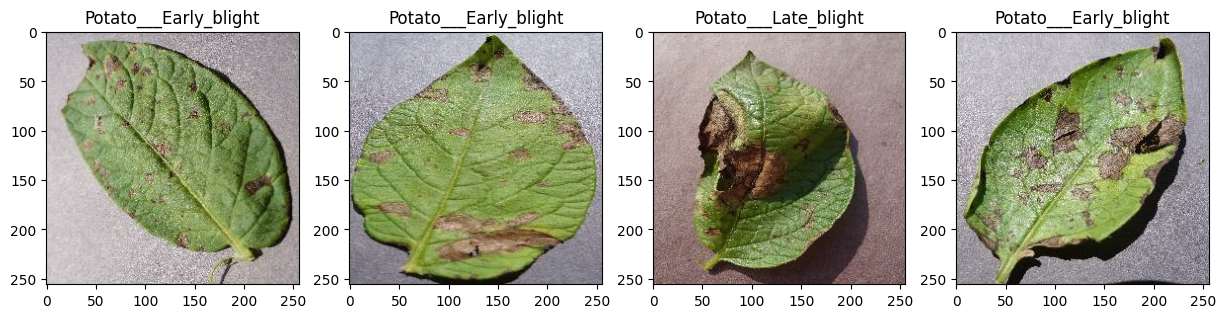

In [ ]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
  for i in range(4):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_name[label_batch[i]])

# training, validation, and test split

In [ ]:
"""dont use this, too messy
create a function instead"""

# total_batches = len(dataset)
# train_size = int(total_batches * 0.8)
# val_size = int(total_batches * 0.1)
# test_size = total_batches - train_size - val_size

# train = dataset.take(train_size)
# val = dataset.skip(train_size).take(val_size)
# test = dataset.skip(train_size + val_size).take(test_size)

'dont use this, too messy\ncreate a function instead'

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train = ds.take(train_size)
    val = ds.skip(train_size).take(val_size)
    test = ds.skip(train_size).skip(val_size)

    return train, val, test

In [ ]:
train, val, test = get_dataset_partitions_tf(dataset)

In [ ]:
print(f'total batch for training examples = {len(train)}')
print(f'total batch for validation examples = {len(val)}')
print(f'total batch for test examples = {len(test)}')

total batch for training examples = 54
total batch for validation examples = 6
total batch for test examples = 8


In [ ]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train = train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build CNN Architecture

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# callback for early stopping
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy')>0.99and logs.get('val_accuracy')>0.99:
      print('\nDesired Accuracy and Validation Accuracy Achieved!')
      self.model.stop_training = True

callback = myCallBack()

In [ ]:
history = model.fit(
    train,
    batch_size=BATCH_SIZE,
    validation_data=val,
    verbose=1,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/50
54/54 [==============================] - 15s 277ms/step - loss: 0.0461 - accuracy: 0.9861 - val_loss: 0.1087 - val_accuracy: 0.9583
Epoch 2/50
54/54 [==============================] - 15s 281ms/step - loss: 0.0566 - accuracy: 0.9832 - val_loss: 0.0495 - val_accuracy: 0.9740
Epoch 3/50
54/54 [==============================] - 15s 278ms/step - loss: 0.0470 - accuracy: 0.9855 - val_loss: 0.0257 - val_accuracy: 0.9896
Epoch 4/50
54/54 [==============================] - 16s 295ms/step - loss: 0.0362 - accuracy: 0.9878 - val_loss: 0.6403 - val_accuracy: 0.8229
Epoch 5/50
54/54 [==============================] - 15s 277ms/step - loss: 0.0436 - accuracy: 0.9844 - val_loss: 0.1008 - val_accuracy: 0.9688
Epoch 6/50
54/54 [==============================] - 15s 276ms/step - loss: 0.0489 - accuracy: 0.9832 - val_loss: 0.1902 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 16s 297ms/step - loss: 0.0514 - accuracy: 0.9850 - val_loss: 0.0404 - val_accuracy: 0.9896

# Model Evaluation

In [ ]:
test_loss, test_accuracy = model.evaluate(test)
print(f'test set loss = {test_loss}')
print(f'test set accuracy = {test_accuracy}')


8/8 [==============================] - 0s 29ms/step - loss: 0.0689 - accuracy: 0.9883
test set loss = 0.06887951493263245
test set accuracy = 0.98828125


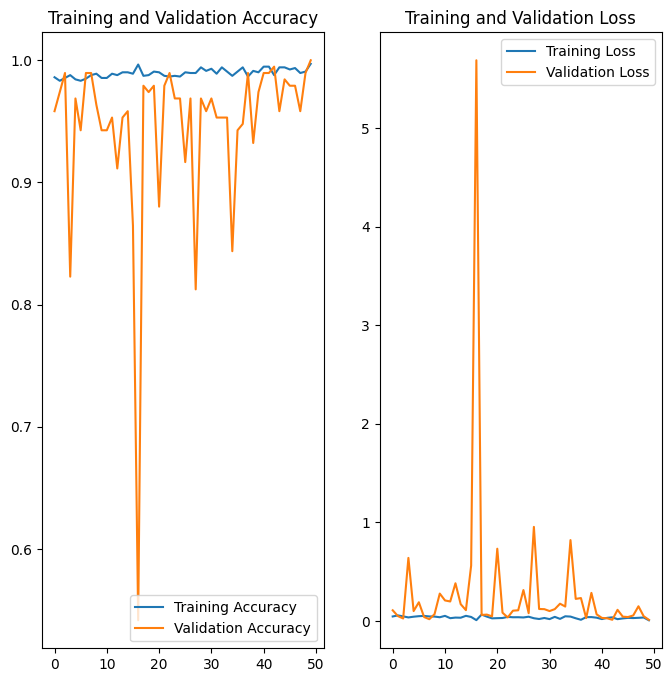

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


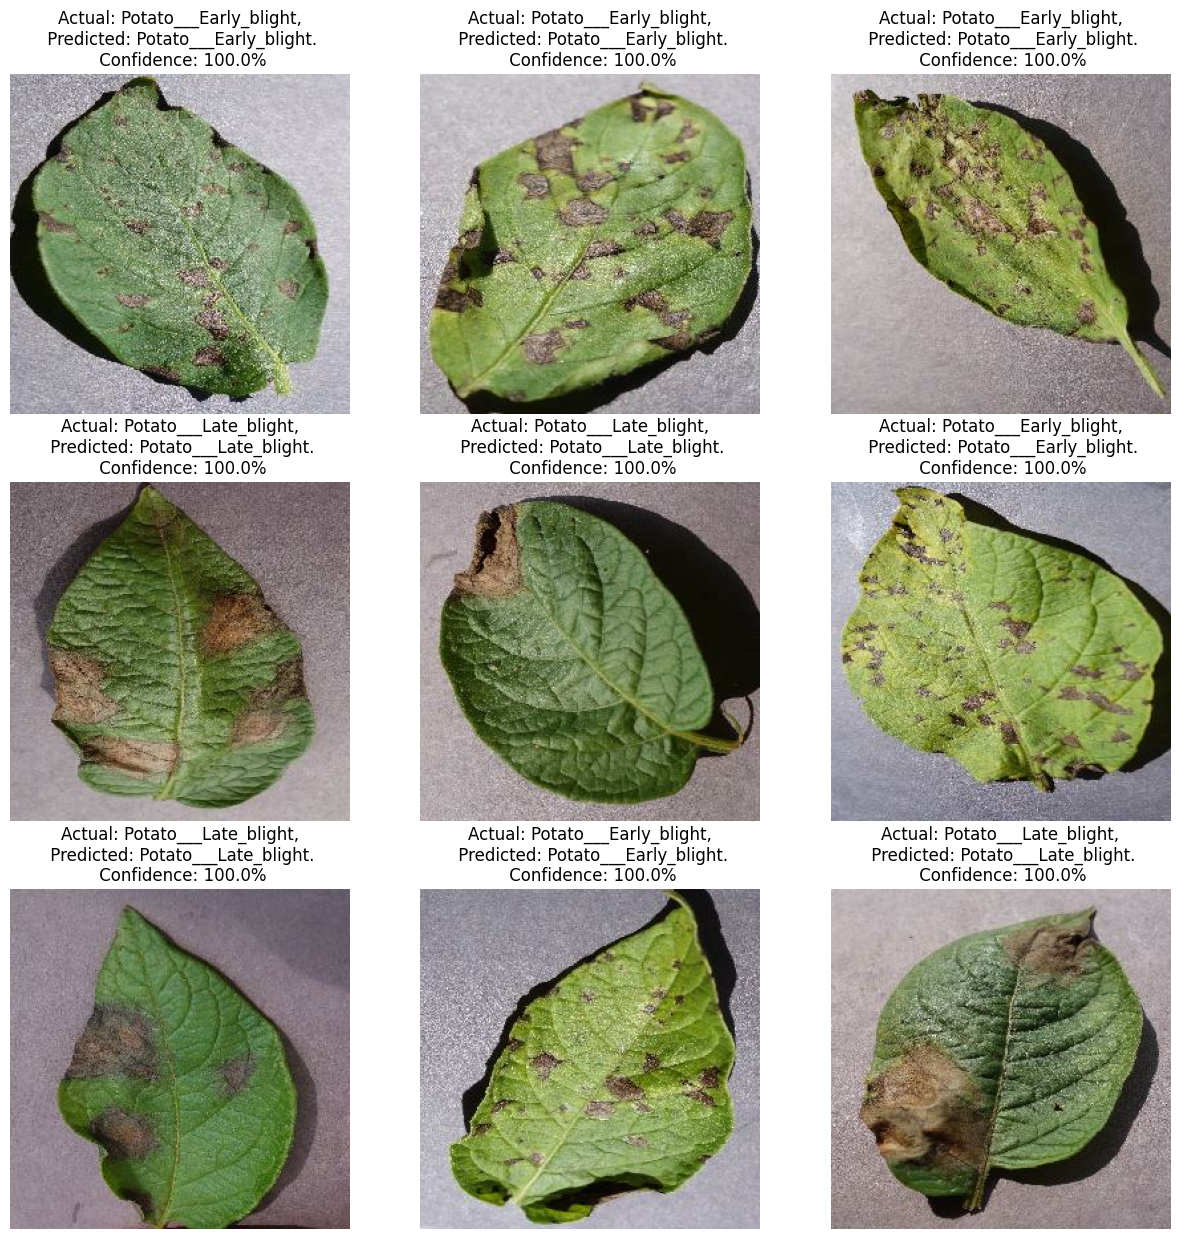

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Save Model

In [ ]:
model.save("Potatoes_Disease.h5")